In [58]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot
from src.data import pai_vertical
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-07 12:32:31,853 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [2]:
ee.Initialize()

In [3]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020', '2021']).filter_within_geometry(sierras)

In [4]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-07 11:29:27,642 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:29:27,949 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:29:29,342 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:29:29,684 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:29:29,852 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [5]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-07 11:32:08,128 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:32:08,644 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:32:10,969 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:32:11,779 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:32:12,102 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [6]:
fire = sierra_firep.get_fire('CASTLE')

In [7]:
matches = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned, 'agbd')

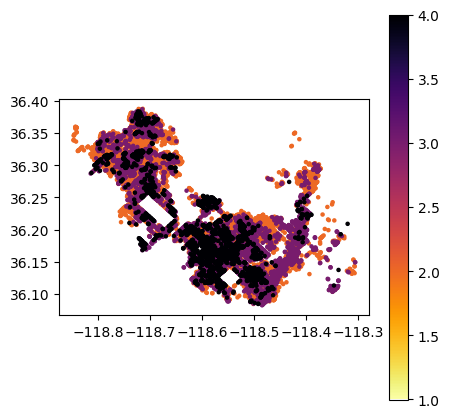

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

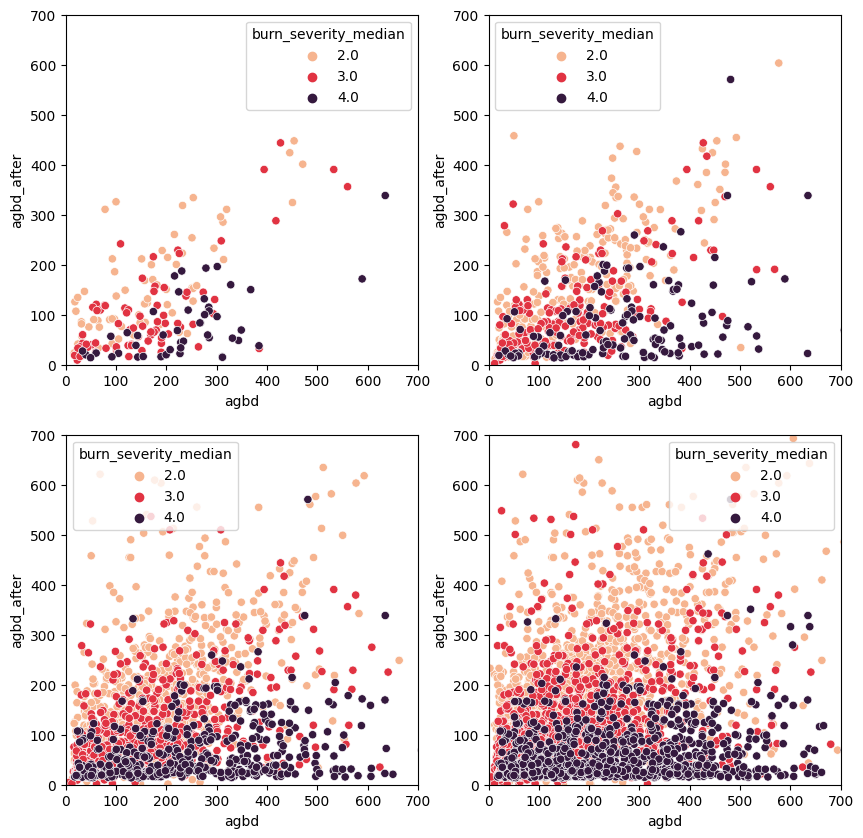

In [13]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

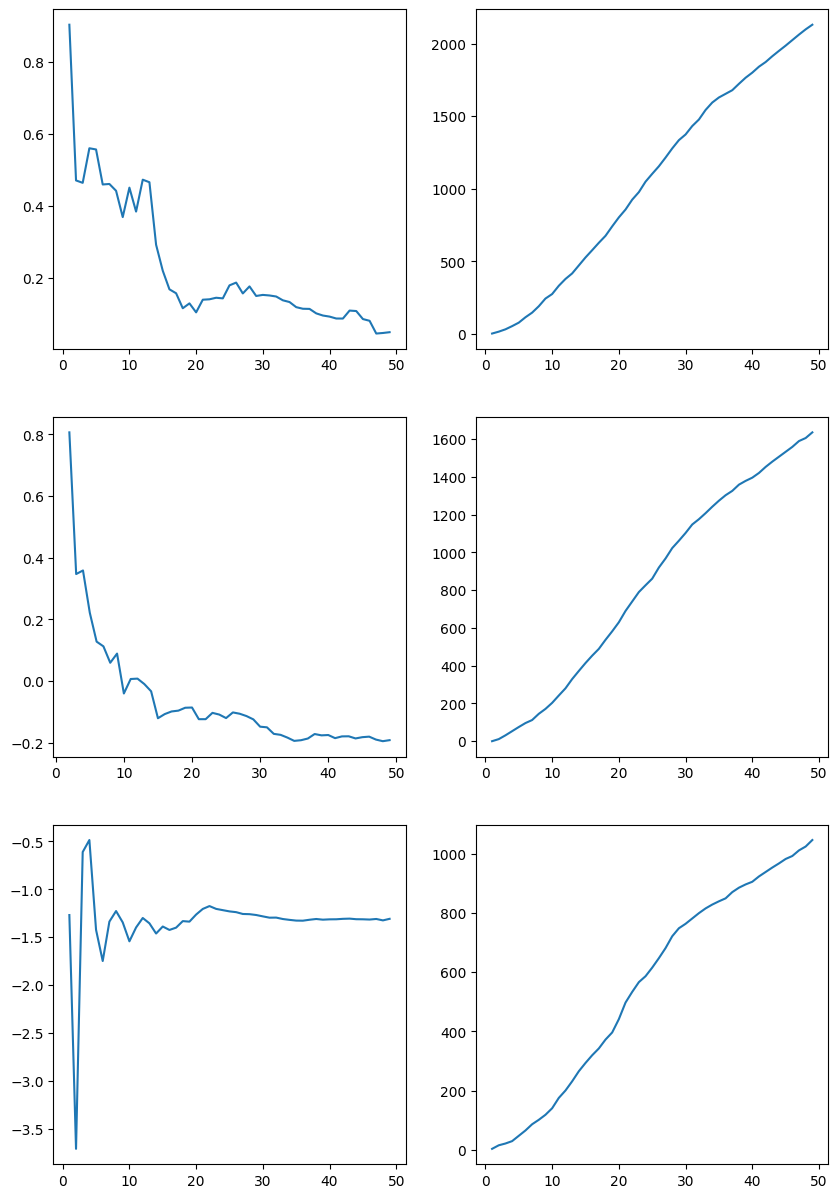

In [14]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [15]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [16]:
close_matches = filter_land_cover(matches[matches.closest_distance < 10])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.76944635].         R squared is : 0.5104321698556602.
The error for coeff = 1 is: 0.37533388271809265.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.62425189].         R squared is : 0.3304534514182462.
The error for coeff = 1 is: -0.20634152618821355.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.17277814].         R squared is : 0.11406055600667753.
The error for coeff = 1 is: -1.5179448896551384.


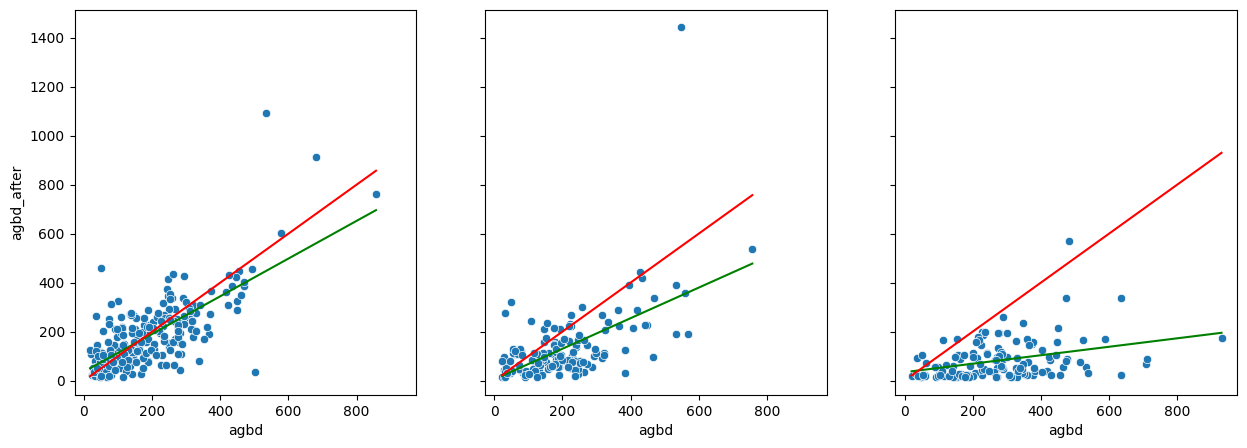

In [17]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

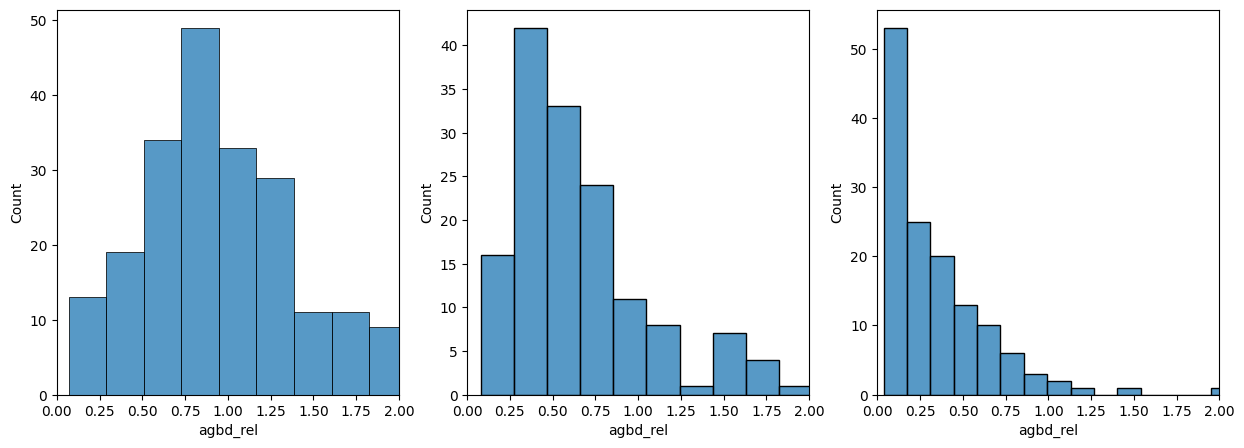

In [18]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000057  1955.459418 -3429.257357     inf      0.083374   
lognorm         0.000057  1983.611563 -3431.817488     inf      0.089489   
norm            0.000058  1973.564343 -3436.763685     inf      0.091430   
gamma           0.000062  1960.158210 -3413.628150     inf      0.102664   
burr            0.000621  1762.432522 -2885.939801     inf      0.696955   

             ks_pvalue  
beta      8.043892e-02  
lognorm   4.952208e-02  
norm      4.215129e-02  
gamma     1.549632e-02  
burr     7.378269e-111  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 31.03it/s]


{'norm': {'loc': 7.866491712662618, 'scale': 102.41330961455435}}


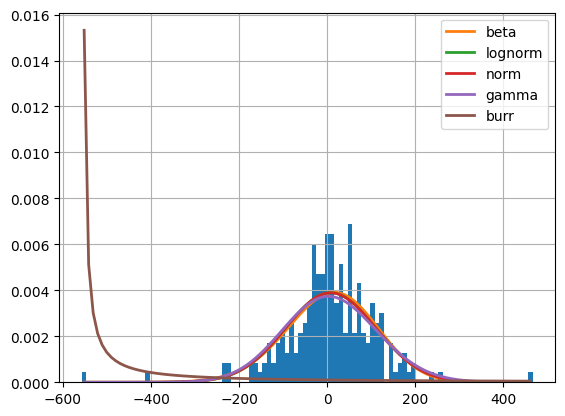

In [19]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000060  2228.341042 -2269.237467     inf      0.089859   
norm            0.000062  2676.736635 -2274.085199     inf      0.103839   
gamma           0.000072  2692.771998 -2244.379138     inf      0.132886   
lognorm         0.000360  1885.415224 -1995.492472     inf      0.813315   
burr            0.000418  1826.687562 -1967.286664     inf      0.732672   

             ks_pvalue  
beta      1.539144e-01  
norm      6.573681e-02  
gamma     7.568079e-03  
lognorm  2.834606e-112  
burr      1.388936e-85  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


{'norm': {'loc': 68.65351321312689, 'scale': 126.16890919691294}}


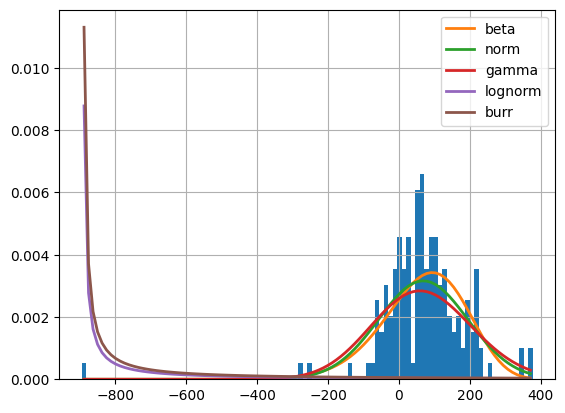

In [20]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000132  1489.551503 -1863.244376     inf      0.051166   
gamma           0.000132  1488.442552 -1868.145146     inf      0.051440   
lognorm         0.000132  1487.422738 -1867.932053     inf      0.056705   
burr            0.000133  1479.037125 -1862.488896     inf      0.061981   
norm            0.000141  1545.750371 -1864.547454     inf      0.074689   

         ks_pvalue  
beta      0.850436  
gamma     0.846012  
lognorm   0.752458  
burr      0.649836  
norm      0.413799  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 26.73it/s]


{'norm': {'loc': 195.07654218112722, 'scale': 147.53367791915954}}


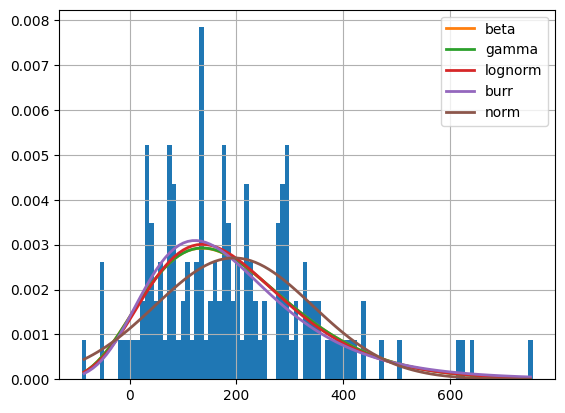

In [21]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

In [22]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9316236972808838, pvalue=8.815460361688565e-09)
Ttest results: TtestResult(statistic=1.1547259025175096, pvalue=0.2494221853972888, df=226)
Wilcoxon test results: WilcoxonResult(statistic=11172.0, pvalue=0.07444951968336005)


In [23]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8033046722412109, pvalue=3.664124938792396e-13)
Ttest results: TtestResult(statistic=6.752596174830618, pvalue=2.7943354985077e-10, df=154)
Wilcoxon test results: WilcoxonResult(statistic=1631.0, pvalue=3.1326169744707877e-15)


In [24]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.952465832233429, pvalue=0.00012190495908726007)
Ttest results: TtestResult(statistic=15.36316744270192, pvalue=1.972694734995806e-31, df=135)
Wilcoxon test results: WilcoxonResult(statistic=112.0, pvalue=5.359210452554276e-23)


## PAI Analysis

In [32]:
matches_l2b = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned_l2b, 'pai')

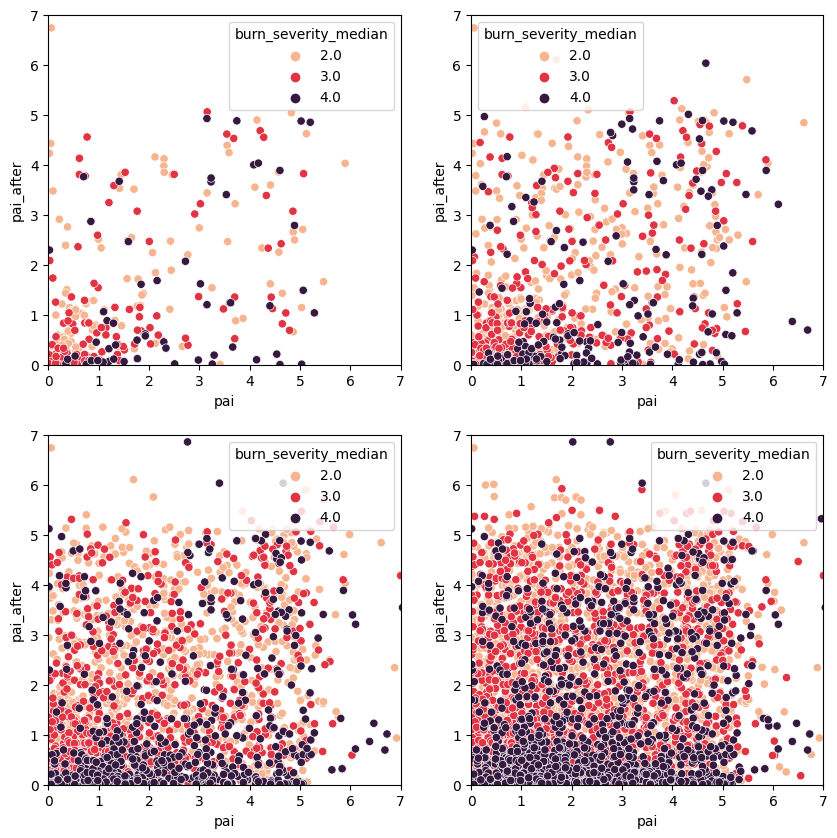

In [36]:
matching_analysis.plot_severity_for_distance(matches_l2b, 'pai', 7)

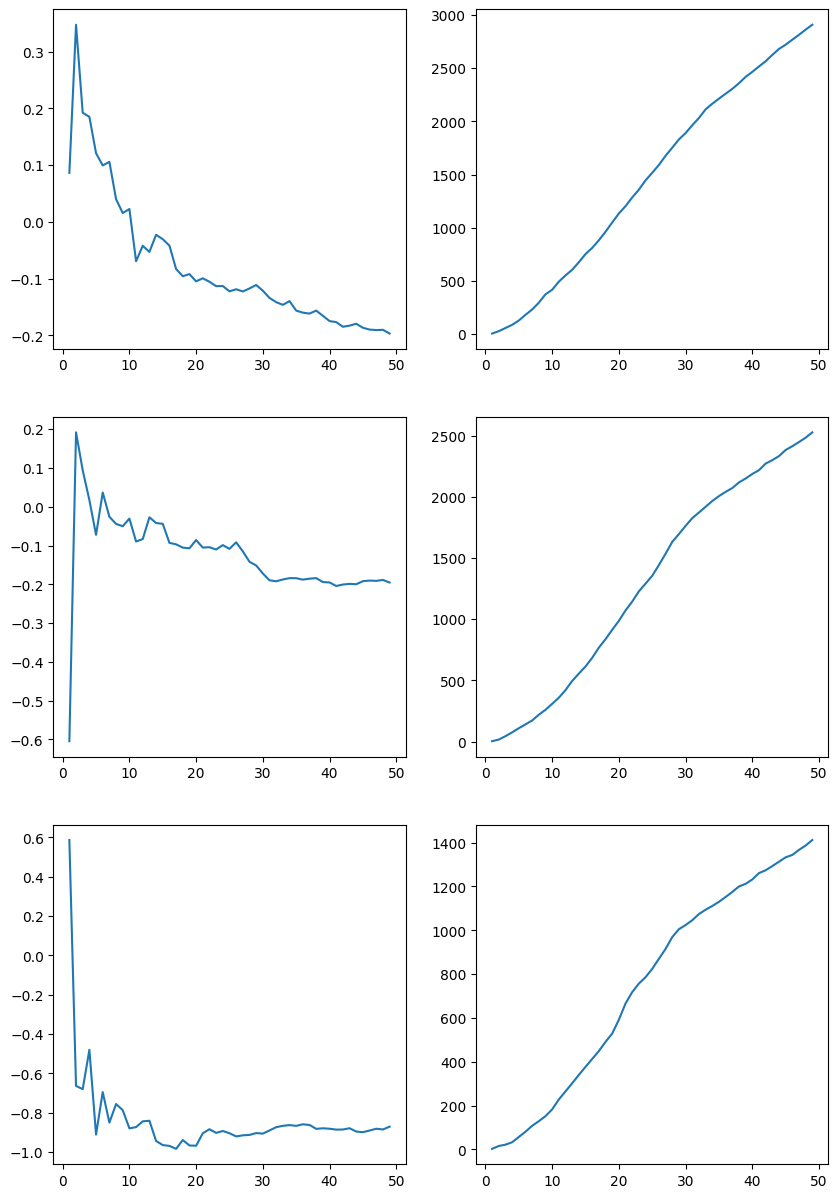

In [38]:
matching_analysis.plot_error_for_distances(matches_l2b, 'pai')

## PAI Z Analysis

In [10]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(fire, gedi_burned_l2b)

In [11]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 20])
close_matches['date_since'] = ((close_matches.match_datetime - fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

In [12]:
unpacked = matching_analysis.transform_pai_z_data(close_matches)

In [64]:
unpacked_rel = matching_analysis.transform_pai_z_data(close_matches, rel=True)

(0.0, 13.0)

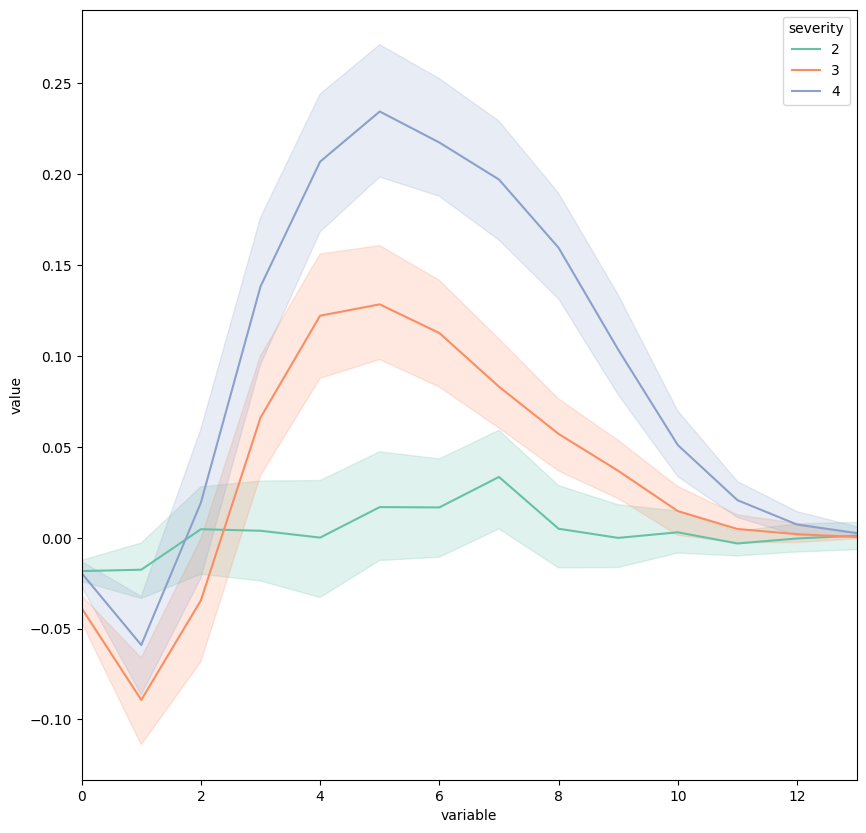

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(unpacked, x='variable', y='value', hue='severity', ax=ax, palette='Set2')
ax.set_xlim((0, 13))

(0.0, 2.0)

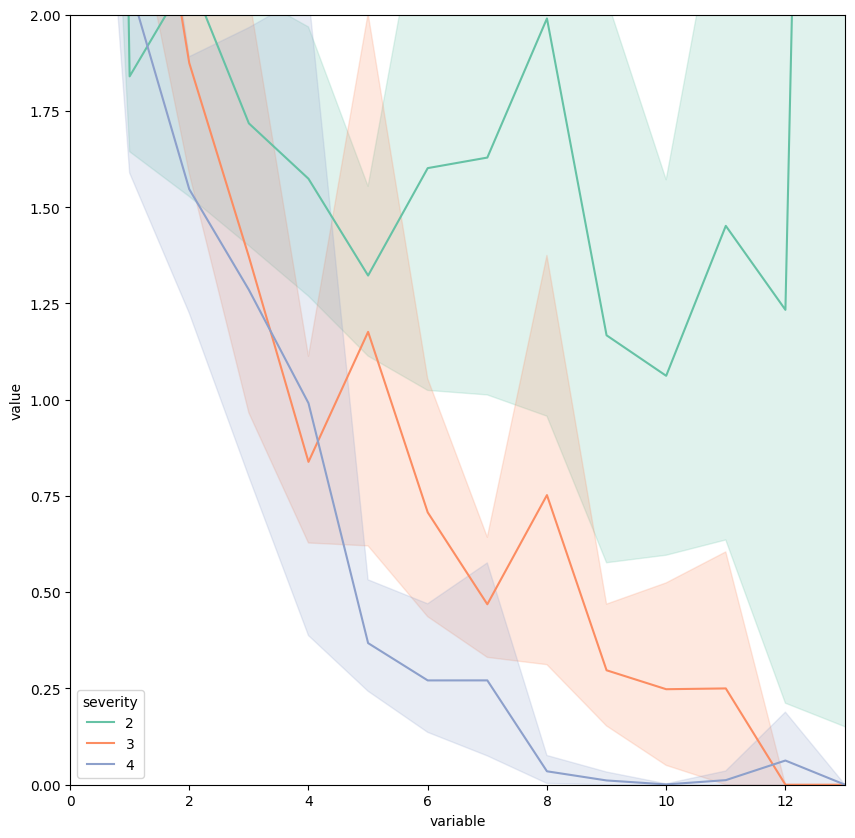

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(unpacked_rel.reset_index(), x='variable', y='value', hue='severity', ax=ax, palette='Set2')
ax.set_xlim((0, 13))
ax.set_ylim((0, 2))

(0.0, 13.0)

<Figure size 2000x500 with 0 Axes>

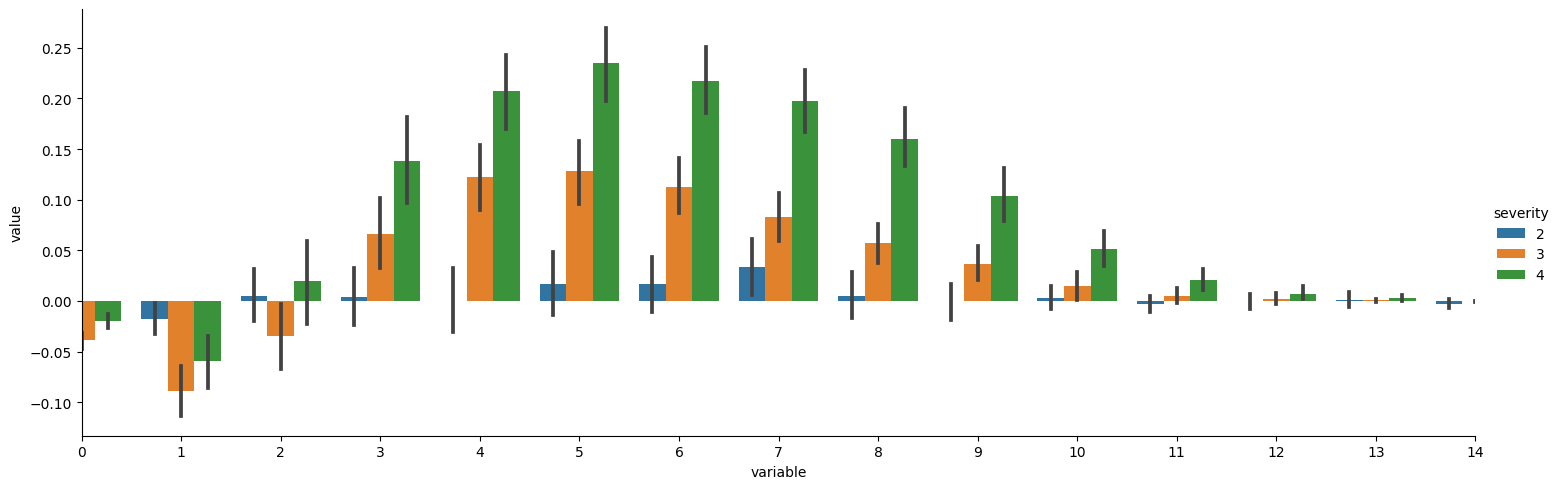

In [15]:
plt.figure(figsize=(20,5))
g = sns.catplot(unpacked, x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
ax.set_xlim((0, 13))

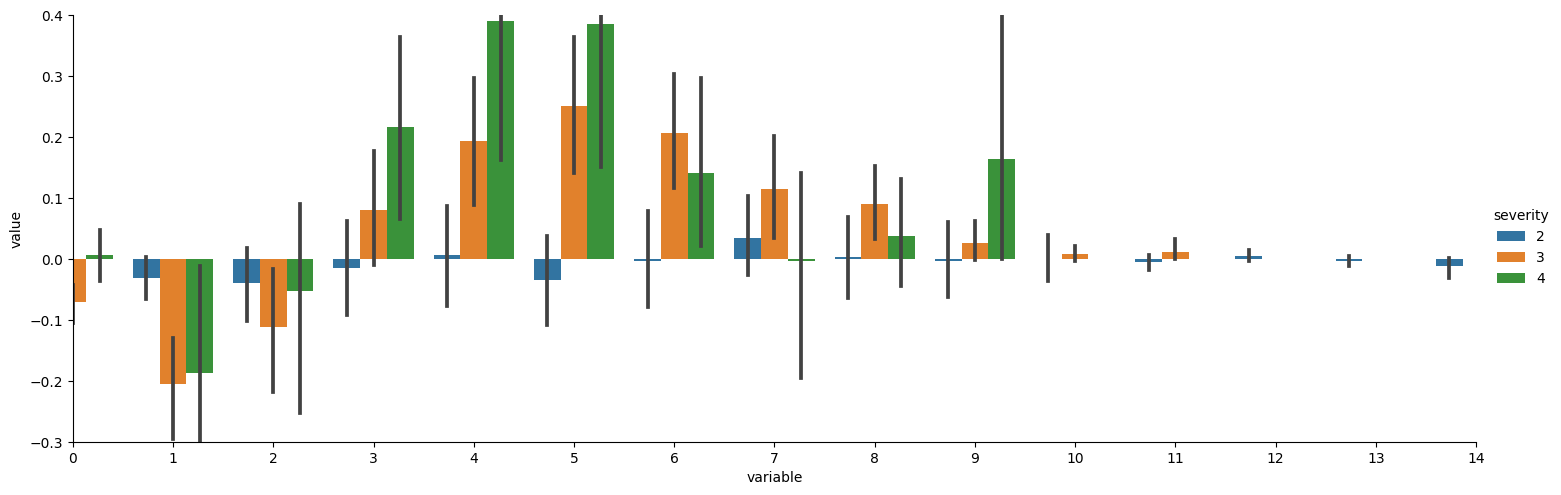

In [16]:
g = sns.catplot(unpacked[unpacked.date_since < 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

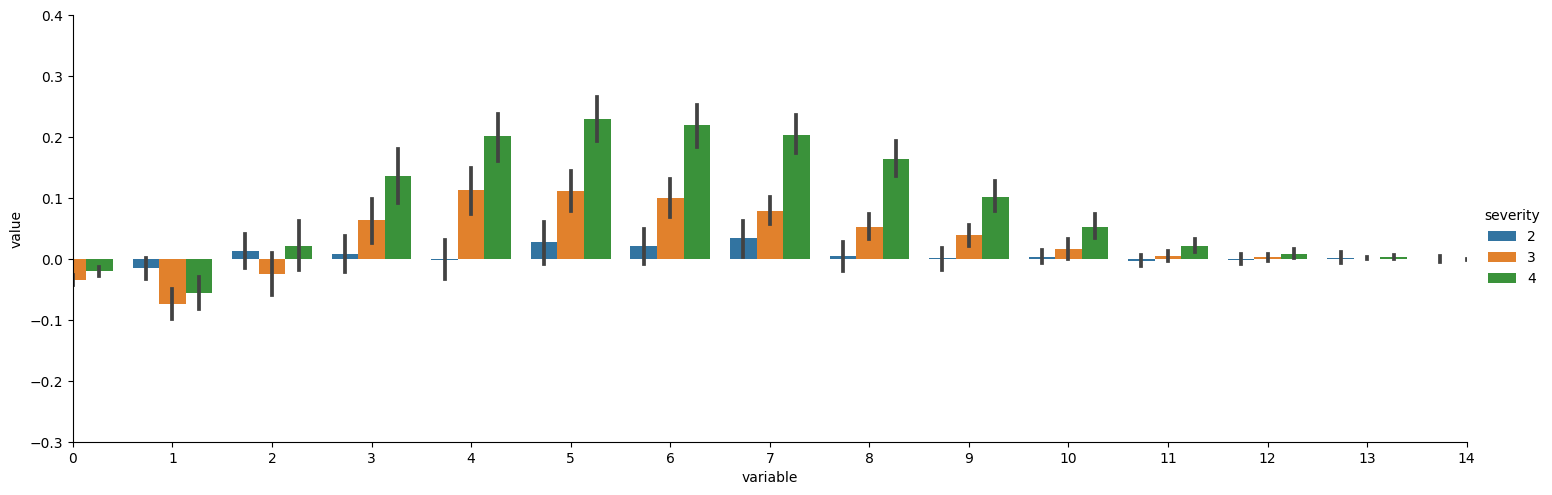

In [17]:
g = sns.catplot(unpacked[unpacked.date_since > 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

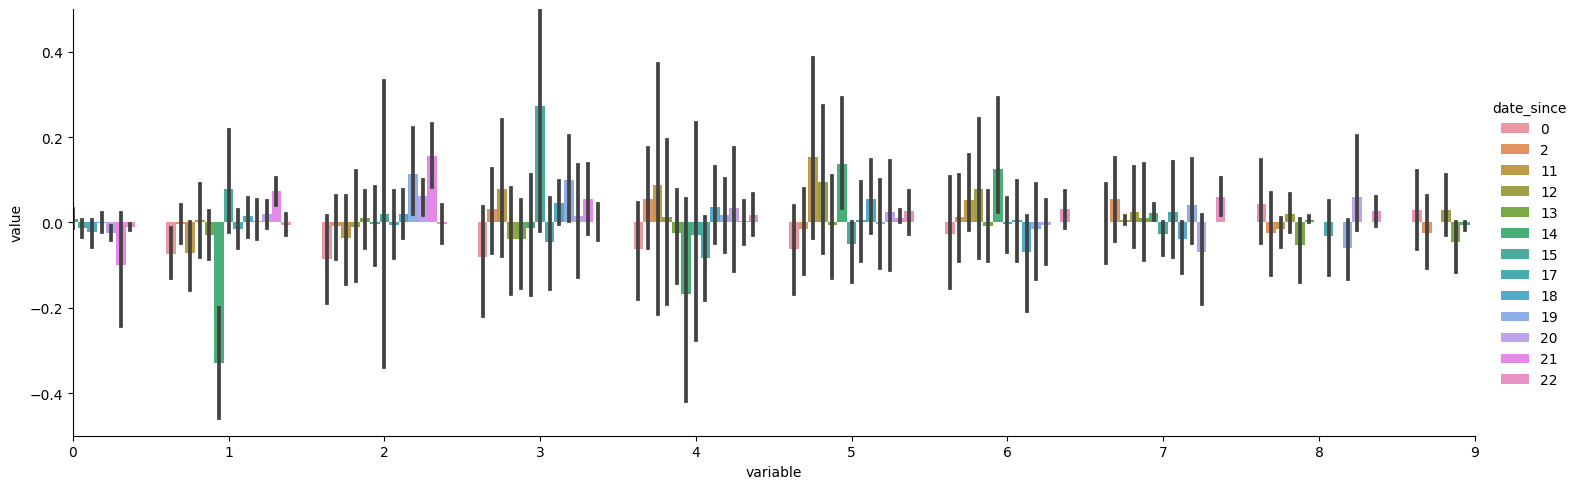

In [18]:
g = sns.catplot(unpacked[unpacked.severity==2], x='variable', y='value', hue='date_since', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-0.5,0.5))

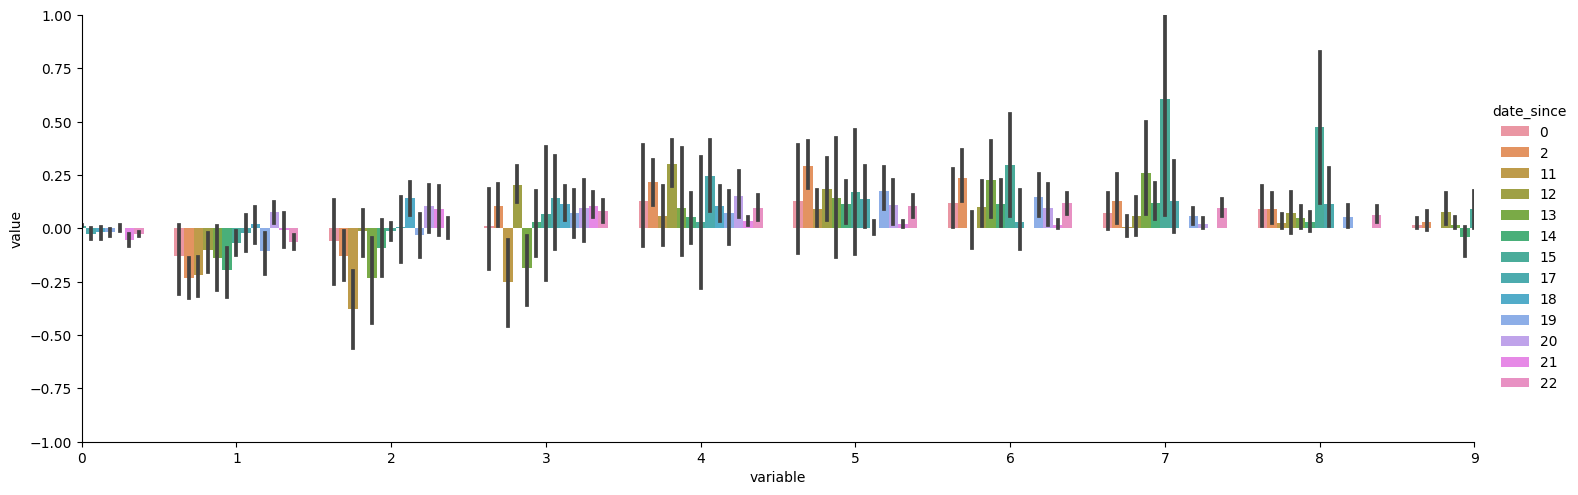

In [19]:
g = sns.catplot(unpacked[unpacked.severity==3], x='variable', y='value', hue='date_since', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-1,1))

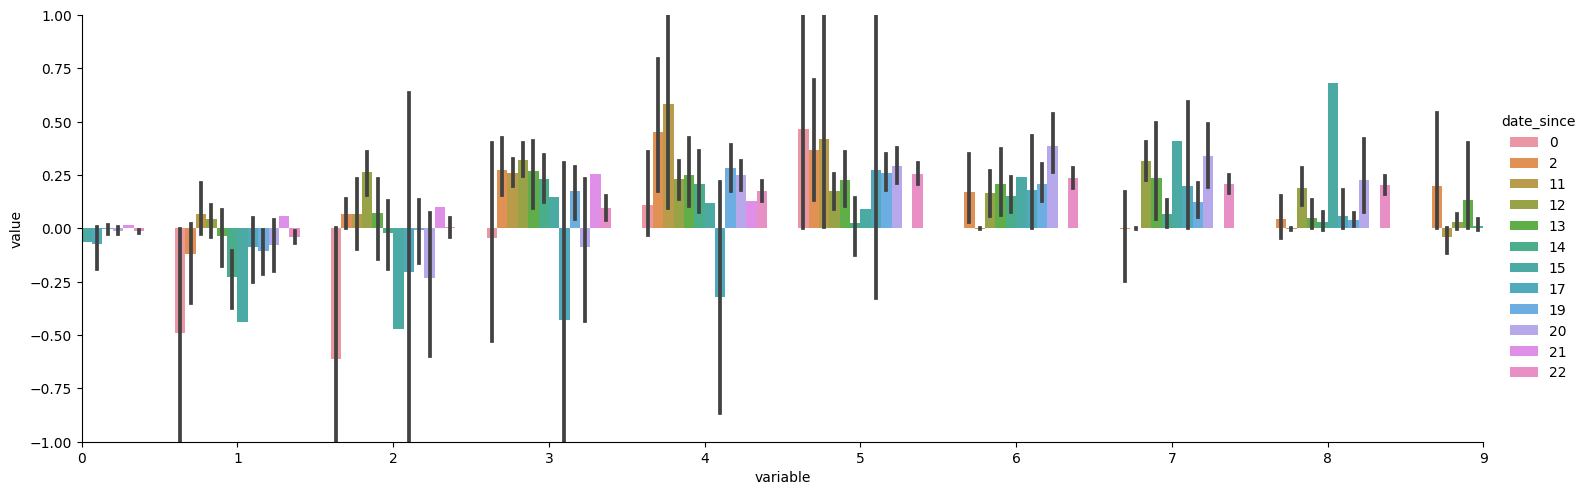

In [20]:
g = sns.catplot(unpacked[unpacked.severity==4], x='variable', y='value', hue='date_since', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-1,1))

In [49]:
unpacked_granular = gedi_matching.add_date_since_burn_categories_granular(unpacked.reset_index())
unpacked_coarse = gedi_matching.add_date_since_burn_categories_coarse(unpacked.reset_index())

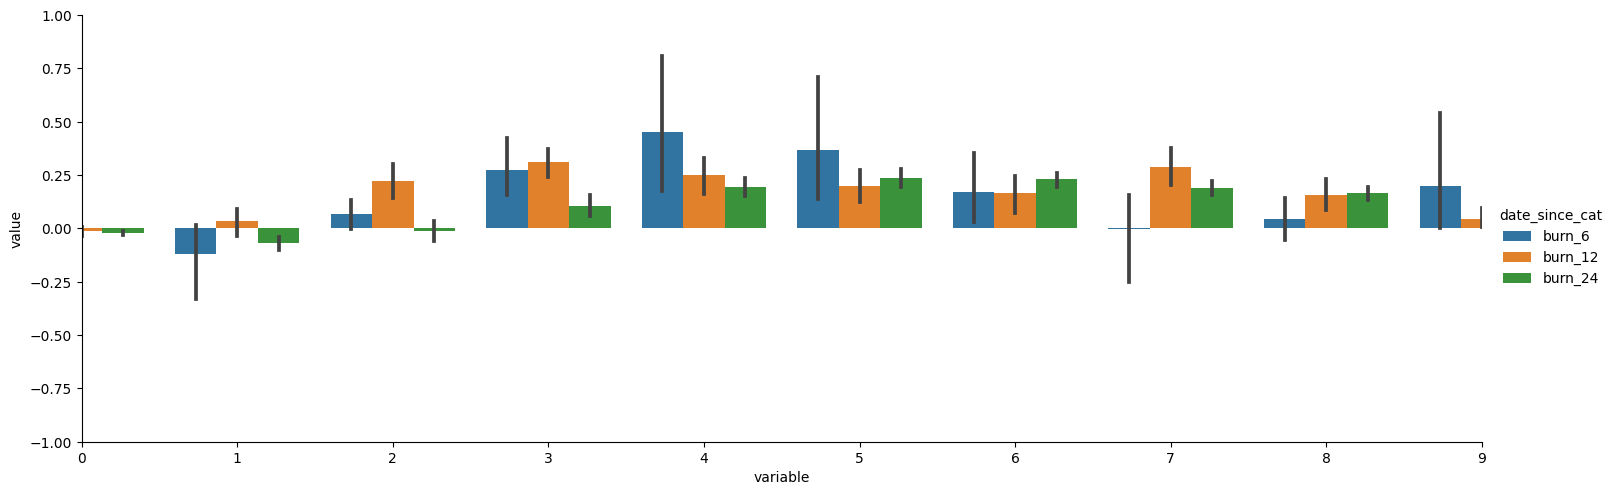

In [50]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==4], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-1,1))

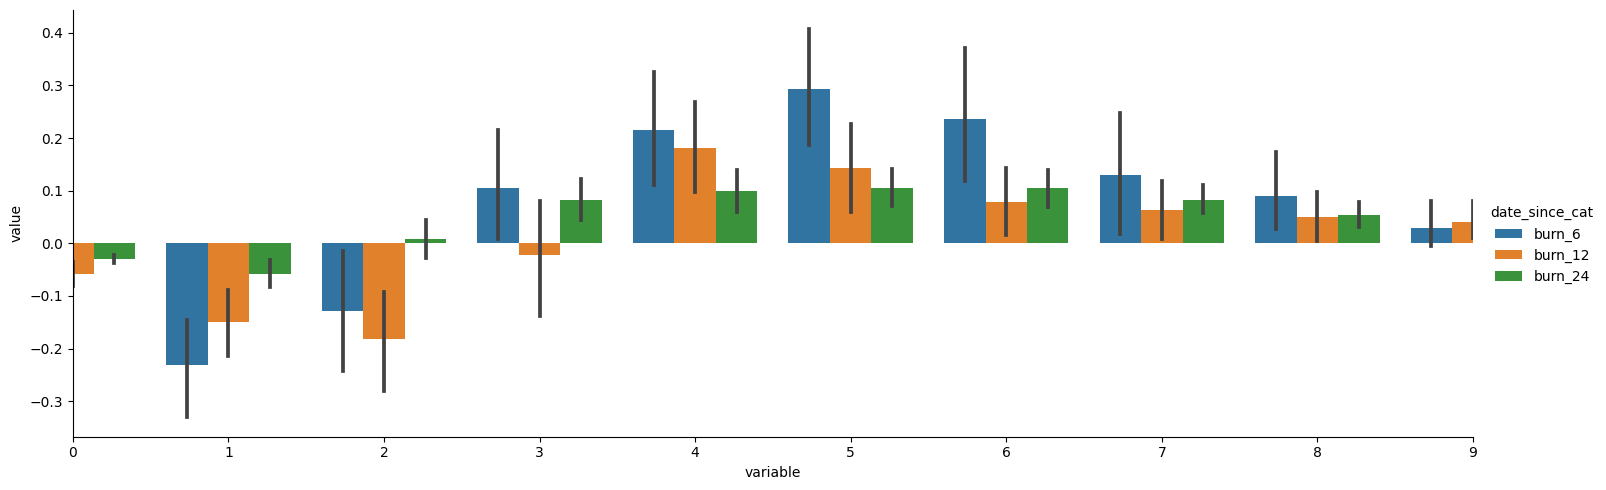

In [51]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==3], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
#g.set(ylim=(-1,1))

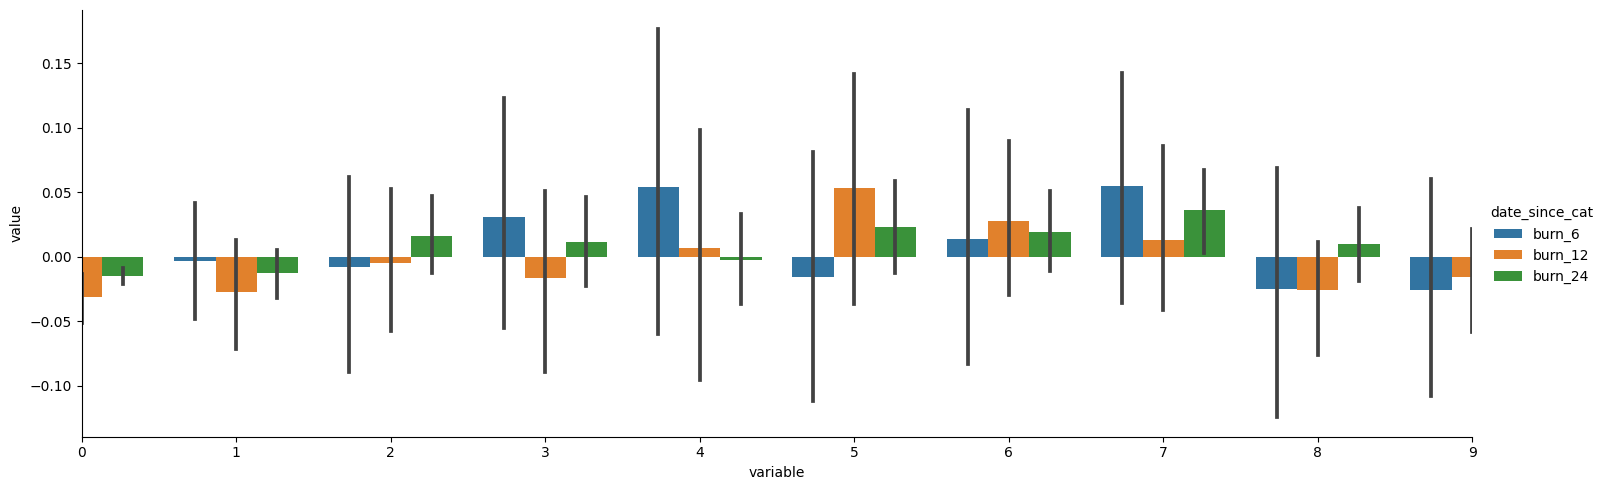

In [52]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==2], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
#g.set(ylim=(-1,1))

<Axes: xlabel='date_since_cat', ylabel='value'>

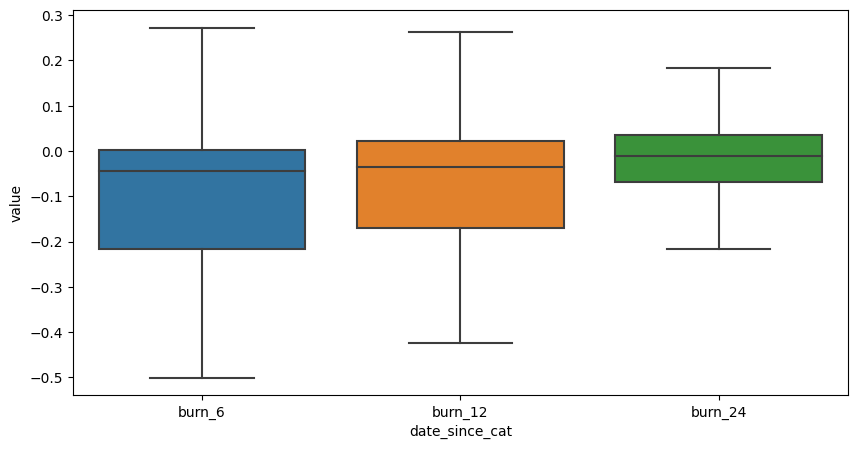

In [57]:
plt.figure(figsize=(10,5))
lala = unpacked_coarse[(unpacked_coarse.severity==3) & (unpacked_coarse.variable < 2)]
sns.boxplot(lala, x='date_since_cat', y='value', showfliers=False)